In [40]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [41]:
# Create your connection.
cnx = sqlite3.connect('/home/julius/thesis/rxitect/logs/mogfn/drugex_v2_tb/generated_mols_0.db')

df = pd.read_sql_query("SELECT * FROM results2", cnx)

In [42]:
reward_history = (df[df["r"] > 1e-32]["r"]).to_numpy()

In [43]:
len(reward_history)

160512

array([    0,     1,     2, ..., 19997, 19998, 19999])

<AxesSubplot: ylabel='r'>

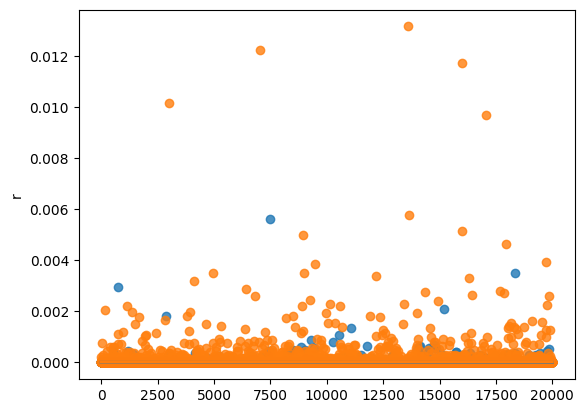

In [239]:
sns.regplot(x=np.arange(20_000), y=df[:20000]["r"], label="first 20K")
sns.regplot(x=np.arange(20_000), y=df[-20000:]["r"], label="last 20K")

In [50]:
import torch

In [51]:
pareto = torch.load("../logs/mogfn/drugex_v2_tb/pareto.pt")

In [67]:
pf = pareto["pareto_front"]

In [84]:
def f(x, y):
    return 50 - (x**2 + y**2)
N =50
xv = np.linspace(-5, 5, N)
yv = np.linspace(-5, 5, N)
x1, y1 = np.meshgrid(xv, yv)
z1 = f(x1, y1)

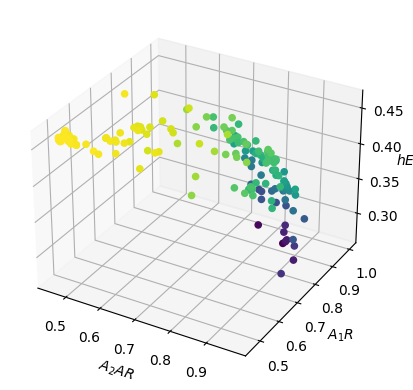

In [240]:
axes = plt.axes(projection="3d")
axes.scatter3D(pf[:,0], pf[:,1], pf[:,2], c=pf[:,2], alpha=1)
axes.set_xlabel("$A_{2}AR$")
axes.set_ylabel("$A_{1}R$")
axes.set_zlabel("$hERG$")
axes.yaxis.set_rotate_label(False)
axes.zaxis.set_rotate_label(False)
plt.savefig("../reports/drugex_v2_beta_32_trajectory_balance_5000.png")
plt.show()
# axes.plot_surface(x1, y1, z1)
# plt.show()

In [102]:
drugexv2_gfn = torch.load("../logs/mogfn/drugex_v2_tb/model_state.pt")

In [108]:
hps = drugexv2_gfn['hps']

In [109]:
hps

{'bootstrap_own_reward': False,
 'learning_rate': 0.0001,
 'global_batch_size': 128,
 'num_emb': 128,
 'num_layers': 6,
 'tb_epsilon': None,
 'illegal_action_logreward': -75,
 'reward_loss_multiplier': 1,
 'temperature_sample_dist': 'uniform',
 'temperature_dist_params': '(32, 32)',
 'weight_decay': 1e-08,
 'num_data_loader_workers': 8,
 'momentum': 0.9,
 'adam_eps': 1e-08,
 'lr_decay': 20000,
 'Z_lr_decay': 20000,
 'clip_grad_type': 'norm',
 'clip_grad_param': 10,
 'random_action_prob': 0.05,
 'num_cond_dim': 35,
 'sampling_tau': 0.95,
 'seed': 0,
 'preference_type': 'seeded_many',
 'algo': 'TB',
 'log_dir': '/home/julius/thesis/rxitect/logs/mogfn/drugex_v2_tb',
 'num_training_steps': 20000,
 'validate_every': 250,
 'valid_sample_cond_info': False,
 'mask_invalid_rewards': False}

In [116]:
state_dict = drugexv2_gfn['models_state_dict'][0]

In [122]:
from rxitect.gflownet.models.frag_graph_gfn import FragBasedGraphGFN
from rxitect.gflownet.contexts.frag_graph_context import FragBasedGraphContext
from rxitect.gflownet.utils.graph_sampler import GraphSampler
from rxitect.gflownet.contexts.envs.graph_building_env import GraphBuildingEnv

In [124]:
ctx = FragBasedGraphContext(num_cond_dim=hps["num_cond_dim"])

In [118]:
gfn = FragBasedGraphGFN(ctx=ctx, estimate_init_state_flow=True)

In [119]:
gfn.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [126]:
env = GraphBuildingEnv(ctx=ctx)
sampler = GraphSampler(ctx, env, max_steps=None, max_nodes=9, rng=np.random.default_rng(123))

In [138]:
from rxitect.gflownet.tasks.a import thermometer
from torch.distributions import Dirichlet


def generate_encoded_ci(n: int, num_prefs: int, rexp_distribution = (32, 32), rng = np.random.default_rng(123)):
    beta = rng.uniform(*rexp_distribution, n).astype(np.float32)
    upper_bound = rexp_distribution[1]
    beta_enc = thermometer(torch.tensor(beta), 32, 0, upper_bound)  # TODO: hyperparameters
    m = Dirichlet(torch.FloatTensor([1.] * num_prefs))
    preferences = m.sample([n])
    encoding = torch.cat([beta_enc, preferences], 1)
    info = {'beta': torch.tensor(beta), 'encoding': encoding, 'preferences': preferences}
    return info

In [142]:
n_samples = 100
ci = generate_encoded_ci(n=n_samples, num_prefs=3)
res = sampler.sample_from_model(model=gfn, n=n_samples, cond_info=ci["encoding"], device="cpu")

In [183]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
IPythonConsole.ipython_useSVG=False  #< set this to False if you want PNGs instead of SVGs

In [180]:
def replenish_stems(g, ctx):
    if hasattr(ctx, "frags_stems"):
        for i in g.nodes:
            g.nodes[i]['stems'] = ctx.frags_stems[g.nodes[i]['v']]
    else:
        raise ValueError("This context does not use stems")

In [190]:
res[0]

{'traj': [(<[], [], [], [], []>, <GraphActionType.AddNode, 0, 61>),
  (<[0], [], [61], ['c1cncnc1'], [[1, 0, 3, 5]]>,
   <GraphActionType.AddNode, 0, 11>),
  (<[0, 1], [(0, 1)], [61, 11], ['c1cncnc1', 'c1ccncc1'], [[1, 0, 3, 5], [2, 0, 1, 4, 5]]>,
   <GraphActionType.AddNode, 1, 5>),
  (<[0, 1, 2], [(0, 1), (1, 2)], [61, 11, 5], ['c1cncnc1', 'c1ccncc1', 'C1CCNCC1'], [[1, 0, 3, 5], [2, 0, 1, 4, 5], [1, 0, 3]]>,
   <GraphActionType.AddNode, 1, 46>),
  (<[0, 1, 2, 3], [(0, 1), (1, 2), (1, 3)], [61, 11, 5, 46], ['c1cncnc1', 'c1ccncc1', 'C1CCNCC1', 'c1cn[nH]c1'], [[1, 0, 3, 5], [2, 0, 1, 4, 5], [1, 0, 3], [0, 1, 3, 4]]>,
   <GraphActionType.SetEdgeAttr, 1, 3, 3_attach, 2>),
  (<[0, 1, 2, 3], [(0, 1), (1, 2), (1, 3)], [61, 11, 5, 46], ['c1cncnc1', 'c1ccncc1', 'C1CCNCC1', 'c1cn[nH]c1'], [[1, 0, 3, 5], [2, 0, 1, 4, 5], [1, 0, 3], [0, 1, 3, 4]]>,
   <GraphActionType.AddNode, 0, 104>),
  (<[0, 1, 2, 3, 4], [(0, 1), (0, 4), (1, 2), (1, 3)], [61, 11, 5, 46, 104], ['c1cncnc1', 'c1ccncc1', 'C1CCNCC1

In [191]:
def sampled_trajs_to_mols(trajs, ctx):
    graphs = []
    for t in trajs:
        G = t["traj"][-1][0]
        _replenish_stems(G, ctx)
        graphs.append(G)
    mols = [ctx.graph_to_mol(G) for G in graphs]
    return mols

In [193]:
mols = sampled_trajs_to_mols(res, ctx)

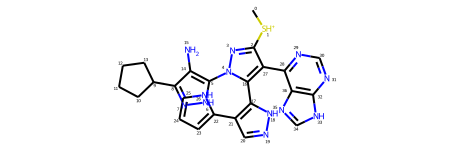

In [217]:
Chem.MolFromSmiles(Chem.MolToSmiles(mols[18]))

In [181]:
g0 = res[0]["traj"][-1][0]
replenish_stems(g0, ctx)

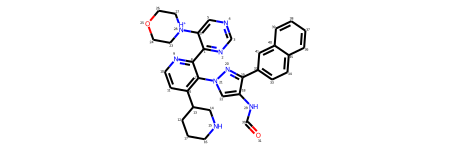

In [184]:
ctx.graph_to_mol(g0)

In [182]:
g0

<[0, 1, 2, 3, 4, 5, 6], [(0, 1), (0, 4), (1, 2), (1, 3), (3, 5), (3, 6)], [61, 11, 5, 46, 104, 20, 18], ['c1cncnc1', 'c1ccncc1', 'C1CCNCC1', 'c1cn[nH]c1', 'C1COCC[NH2+]1', 'NC=O', 'c1ccc2ccccc2c1'], [[1, 0, 3, 5], [2, 0, 1, 4, 5], [1, 0, 3], [0, 1, 3, 4], [5], [0, 1], [0]]>

/tmp/ipykernel_67046/1262199867.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["fr_0"])
/tmp/ipykernel_67046/1262199867.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_2["fr_0"])


<AxesSubplot: xlabel='fr_0', ylabel='Density'>

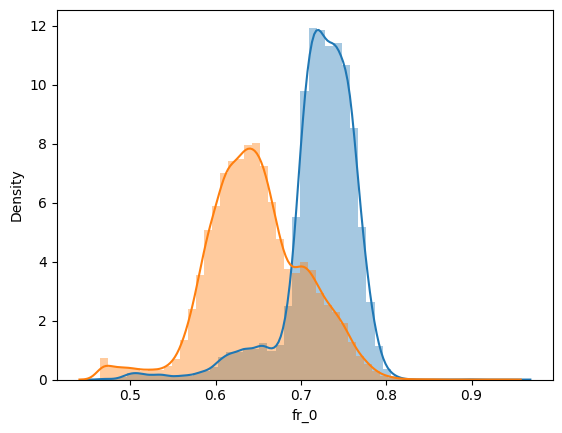

In [18]:
sns.distplot(data["fr_0"])
sns.distplot(data_2["fr_0"])

<AxesSubplot: ylabel='fr_0'>

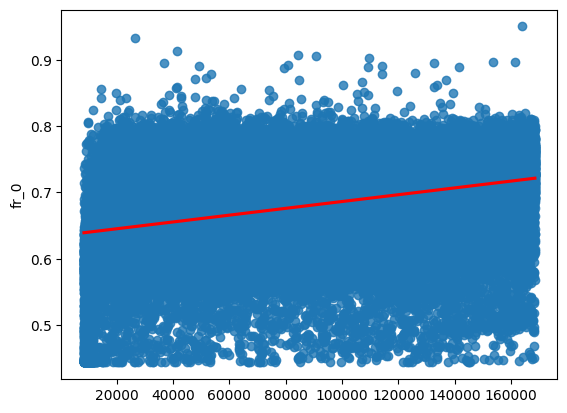

In [27]:
# sns.lineplot(df96["fr_0"])
sns.regplot(x=df96.index, y=df96["fr_0"], fit_reg=True, line_kws={"color": "red"})

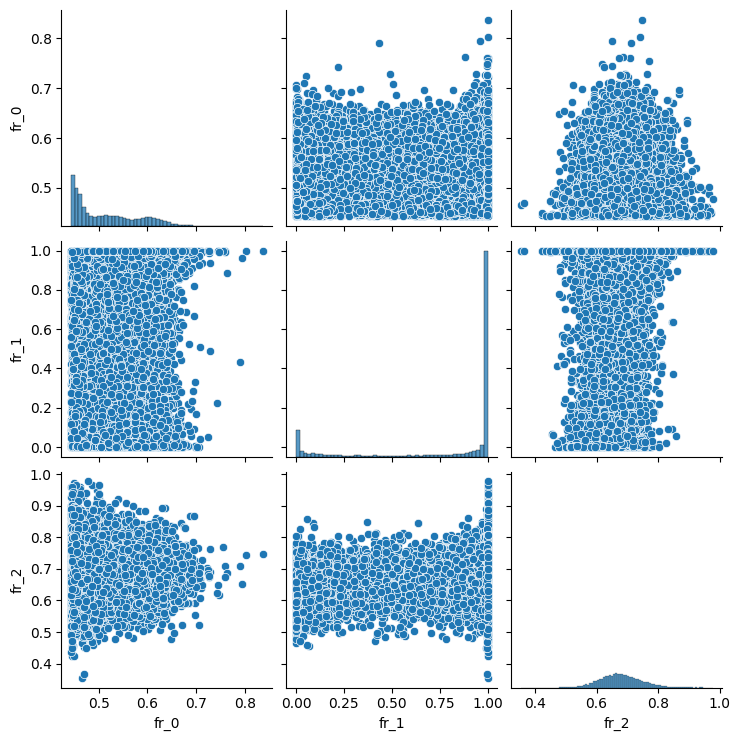

In [43]:
g = sns.pairplot(data[["fr_0", "fr_1", "fr_2"]])
# g = sns.pairplot(data_2[["fr_0", "fr_1", "fr_2"]], kind="kde")
# g.axes[0,0].set_xlim((0, 1))
# g.axes[0,1].set_xlim((0, 1))
# g.axes[0,2].set_xlim((0, 1))
# g.axes[0,0].set_ylim((0, 1))
# g.axes[1,1].set_ylim((0, 1))
# g.axes[2,2].set_ylim((0, 1))
# g.map_upper(sns.scatterplot)
# ax2 = plt.twinx()
# sns.scatterplot(x=data["fr_0"], y=data["pref_0"], color="r", ax=ax2)

In [49]:
sns.scatterplot(x=data["fr_1", "fr_2"], y=data["pref_1", "pref_2"])

KeyError: ('fr_1', 'fr_2')

<AxesSubplot: ylabel='fr_1'>

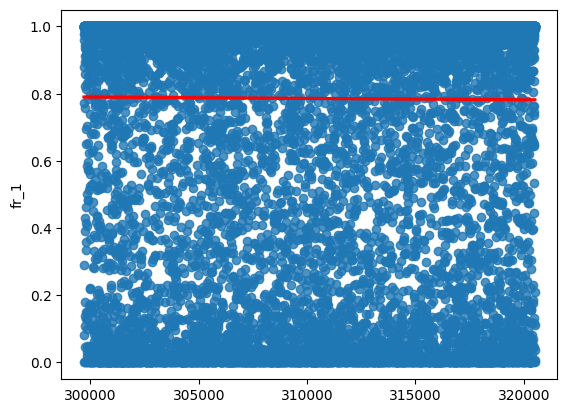

In [39]:
sns.regplot(x=data.index, y="fr_1", data=data, fit_reg=True, line_kws={"color": "red"})

In [ ]:
0.8**32

In [ ]:
import math
math.log(32, 0.0007922816251426448)

In [ ]:
math.log(0.0007922816251426448, 32)

In [ ]:
import torch

In [ ]:
pareto = torch.load("../logs/moo/drugex_v2_tb/pareto.pt")

In [ ]:
sns.displot(pareto["pareto_front"])

In [44]:
import torch

In [118]:
diri = torch.distributions.Dirichlet(torch.FloatTensor([5., 1., 1.]))

In [120]:
diri.sample([5])

tensor([[0.8637, 0.0170, 0.1192],
        [0.7683, 0.0884, 0.1433],
        [0.8626, 0.1056, 0.0318],
        [0.5099, 0.4842, 0.0059],
        [0.8084, 0.1875, 0.0041]])

In [121]:
stuff = torch.load("/home/julius/thesis/rxitect/logs/moo/synth_a2a_tb/model_state.pt")

In [124]:
hps = stuff["hps"]

In [125]:
hps

{'bootstrap_own_reward': False,
 'learning_rate': 0.0001,
 'global_batch_size': 128,
 'num_emb': 128,
 'num_layers': 6,
 'tb_epsilon': None,
 'illegal_action_logreward': -75,
 'reward_loss_multiplier': 1,
 'temperature_sample_dist': 'uniform',
 'temperature_dist_params': '(32, 32)',
 'weight_decay': 1e-08,
 'num_data_loader_workers': 8,
 'momentum': 0.9,
 'adam_eps': 1e-08,
 'lr_decay': 20000,
 'Z_lr_decay': 20000,
 'clip_grad_type': 'norm',
 'clip_grad_param': 10,
 'random_action_prob': 0.05,
 'num_cond_dim': 35,
 'sampling_tau': 0.95,
 'seed': 0,
 'preference_type': 'seeded_many',
 'algo': 'TB',
 'log_dir': '/home/julius/thesis/rxitect/logs/moo/synth_a2a_tb',
 'num_training_steps': 10000,
 'validate_every': 250,
 'valid_sample_cond_info': False,
 'mask_invalid_rewards': False}